In [108]:
#import necessary packages
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif, chi2, f_regression

In [2]:
#import data
PL20_21_fixtures = pd.read_csv('Data/2020-21/Fixtures/PL20_21_features.csv')
PL20_21_lineups = pd.read_csv('Data/2020-21/Players/PL2020_lineups.csv')
PL20_21_player_stats = pd.read_csv('Data/2020-21/Players/PL2020_total.csv')
PL20_21_lineups['player_id'] = PL20_21_lineups['player'] + PL20_21_lineups['team'] + PL20_21_lineups['date'].astype(str)
PL20_21_lineups['game_id'] = PL20_21_lineups['team'] + PL20_21_lineups['date'].astype(str)
PL20_21_lineups
PL20_21_player_stats = PL20_21_player_stats.rename(columns={'player_ID':'player_id','game_ID':'game_id'})

In [3]:
PL20_21_player_stats

,Unnamed: 0,player_fl,player,date,team,team_rating,category,position_fl,minutes_fl,minutes_rating,...,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,opponent_team,selected,player_id,game_id
0,0,Aaron Connolly,Aaron Connolly,2020-09-14,Brighton & Hove Albion,Brighton & Hove Albion,Forward,FWD,45,46.0,...,1,0,0,0,55,True,5,32205,Aaron ConnollyBrighton & Hove Albion2020-09-14,Brighton & Hove Albion2020-09-14
1,1,Aaron Cresswell,Aaron Cresswell,2020-09-12,West Ham United,West Ham United,Defender,DEF,90,90.0,...,1,0,0,0,50,True,14,70232,Aaron CresswellWest Ham United2020-09-12,West Ham United2020-09-12
2,2,Aaron Mooy,0,2020-09-14,Brighton & Hove Albion,NaN,NaN,MID,0,NaN,...,0,0,0,0,50,True,5,2010,0Brighton & Hove Albion2020-09-14,Brighton & Hove Albion2020-09-14
3,3,Aaron Ramsdale,Aaron Ramsdale,2020-09-14,Sheffield United,Sheffield United,Goalkeeper,GK,90,90.0,...,1,0,0,0,50,True,20,462939,Aaron RamsdaleSheffield United2020-09-14,Sheffield United2020-09-14
4,4,Abdoulaye Doucouré,Abdoulaye Doucouré,2020-09-13,Everton,Everton,Midfield,MID,90,90.0,...,3,0,0,0,55,False,17,143040,Abdoulaye DoucouréEverton2020-09-13,Everton2020-09-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24376,24376,Aaron Ramsdale,Aaron Ramsdale,2021-05-23,Sheffield United,Sheffield United,Goalkeeper,GK,90,90.0,...,9,13618,17381,3763,46,True,4,162985,Aaron RamsdaleSheffield United2021-05-23,Sheffield United2021-05-23
24377,24377,Adrien Silva,0,2021-05-23,Leicester City,NaN,NaN,MID,0,NaN,...,0,-16,0,16,44,True,17,16396,0Leicester City2021-05-23,Leicester City2021-05-23
24378,24378,Sidnei Tavares,Sidnei Tavares,2021-05-23,Leicester City,NaN,NaN,MID,0,NaN,...,0,32,60,28,44,True,17,337,Sidnei TavaresLeicester City2021-05-23,Leicester City2021-05-23
24379,24379,Kalvin Phillips,Kalvin Phillips,2021-05-23,Leeds United,Leeds United,Midfield,MID,90,90.0,...,6,210,789,579,49,True,18,74008,Kalvin PhillipsLeeds United2021-05-23,Leeds United2021-05-23


In [4]:
PL20_21_fixtures

,Unnamed: 0,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,Elo_h_after,Elo_a_after,Elo_h_before,Elo_a_before,goalsDifference,shotsDifference,cornersDifference,ewmDifference,elo_difference,form_difference
0,0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,...,1515.00,1485.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,...,1515.00,1485.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,3,E0,2020-09-12,20:00,West Ham United,Newcastle United,0,2,A,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,4,E0,2020-09-13,14:00,West Bromwich Albion,Leicester City,0,3,A,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,375,E0,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,1,...,1591.89,1439.73,1582.38,1449.24,2.500000,16.500000,12.833333,19.313782,133.14,5.500000
376,376,E0,2021-05-23,16:00,Manchester City,Everton,5,0,H,2,...,1659.36,1508.70,1649.79,1518.27,2.166667,1.666667,6.000000,24.719180,131.52,1.666667
377,377,E0,2021-05-23,16:00,Sheffield United,Burnley,1,0,H,1,...,1358.16,1420.86,1338.90,1440.12,-4.833333,-8.333333,-12.500000,-19.400129,-101.22,-0.500000
378,378,E0,2021-05-23,16:00,West Ham United,Southampton,3,0,H,2,...,1560.00,1420.08,1549.98,1430.10,2.833333,-3.500000,-6.666667,18.155503,119.88,2.500000


In [5]:
def get_wk(fixtures):
    home = fixtures[['HomeTeam', 'Wk_h', 'game_home_ID']]
    away = fixtures[['AwayTeam', 'Wk_a', 'game_away_ID']]
    home = home.rename(columns={'HomeTeam':'Team','Wk_h':'wk', 'game_home_ID': 'game_id'})
    away = away.rename(columns={'AwayTeam':'Team','Wk_a':'wk', 'game_away_ID': 'game_id'})
    return home.append(away)
game_weeks = get_wk(PL20_21_fixtures)
game_weeks


C:\Users\giuli\AppData\Local\Temp\ipykernel_10356\392273660.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return home.append(away)


,Team,wk,game_id
0,Fulham,1,Fulham2020-09-12
1,Crystal Palace,1,Crystal Palace2020-09-12
2,Liverpool,1,Liverpool2020-09-12
3,West Ham United,1,West Ham United2020-09-12
4,West Bromwich Albion,1,West Bromwich Albion2020-09-13
...,...,...,...
375,Crystal Palace,38,Crystal Palace2021-05-23
376,Everton,38,Everton2021-05-23
377,Burnley,38,Burnley2021-05-23
378,Southampton,38,Southampton2021-05-23


In [6]:
PL20_21_lineups_tmp =  pd.merge(PL20_21_lineups, game_weeks[['game_id', 'wk']], on= 'game_id', how='left')
PL20_21_player_stats_tmp =  pd.merge(PL20_21_player_stats, game_weeks[['game_id', 'wk']], on= 'game_id', how='left')
PL20_21_lineups_tmp = pd.merge(PL20_21_lineups_tmp, PL20_21_player_stats_tmp[['player_id', 'category']], on= 'player_id')
PL20_21_lineups_tmp

,player,team,matchweek,date,start11,player_id,game_id,wk,category
0,Marek Rodák,Fulham,1.0,2020-09-12,True,Marek RodákFulham2020-09-12,Fulham2020-09-12,1,Goalkeeper
1,Michael Hector,Fulham,1.0,2020-09-12,True,Michael HectorFulham2020-09-12,Fulham2020-09-12,1,Defender
2,Denis Odoi,Fulham,1.0,2020-09-12,True,Denis OdoiFulham2020-09-12,Fulham2020-09-12,1,Defender
3,Neeskens Kebano,Fulham,1.0,2020-09-12,True,Neeskens KebanoFulham2020-09-12,Fulham2020-09-12,1,Forward
4,Tom Cairney,Fulham,1.0,2020-09-12,True,Tom CairneyFulham2020-09-12,Fulham2020-09-12,1,Midfield
...,...,...,...,...,...,...,...,...,...
14638,Michael Obafemi,Southampton,38.0,2021-05-23,False,Michael ObafemiSouthampton2021-05-23,Southampton2021-05-23,38,Forward
14639,Nathan Tella,Southampton,38.0,2021-05-23,False,Nathan TellaSouthampton2021-05-23,Southampton2021-05-23,38,Forward
14640,Theo Walcott,Southampton,38.0,2021-05-23,False,Theo WalcottSouthampton2021-05-23,Southampton2021-05-23,38,NaN
14641,Dan Nlundulu,Southampton,38.0,2021-05-23,False,Dan NlunduluSouthampton2021-05-23,Southampton2021-05-23,38,NaN


In [12]:
PL20_21_fixtures_tmp = PL20_21_fixtures[['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'game_home_ID', 'game_away_ID', 'Wk_h', 'Wk_a']]

In [16]:
df1 = PL20_21_fixtures_tmp.iloc[:95]
df2 = PL20_21_fixtures_tmp.iloc[95:190]
df3 = PL20_21_fixtures_tmp.iloc[190:285]
df4 = PL20_21_fixtures_tmp.iloc[285:]
df2

,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,game_home_ID,game_away_ID,Wk_h,...,rating_a_gk,rating_a_df,rating_a_mf,rating_a_att,rating_a_bench,influence_a,creativity_a,threat_a,bps_a,selected_a
95,2020-11-29,19:15,Arsenal,Wolverhampton Wanderers,1,2,A,Arsenal2020-11-29,Wolverhampton Wanderers2020-11-29,10,...,40.452239,90.963826,76.875469,101.841213,83.850623,141.966066,122.659777,133.439527,121.618296,4.126143e+06
96,2020-11-30,17:30,Leicester City,Fulham,1,2,A,Leicester City2020-11-30,Fulham2020-11-30,10,...,54.635593,158.846781,37.035165,72.159985,78.134802,190.710210,115.113320,117.186915,141.358809,3.804404e+05
97,2020-11-30,20:00,West Ham United,Aston Villa,2,1,H,West Ham United2020-11-30,Aston Villa2020-11-30,10,...,40.960091,101.111687,48.775247,110.949602,26.989764,185.201800,119.294131,206.242782,163.324363,6.679388e+06
98,2020-12-05,12:30,Burnley,Everton,1,1,D,Burnley2020-12-05,Everton2020-12-05,10,...,51.394783,86.880580,47.494726,107.458705,49.824702,179.698413,103.554986,144.213085,131.914178,8.168391e+06
99,2020-12-05,15:00,Manchester City,Fulham,2,0,H,Manchester City2020-12-05,Fulham2020-12-05,10,...,53.338856,132.626102,55.700056,74.730228,62.516179,220.365440,107.662942,126.770095,148.458213,3.801734e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,2021-01-26,18:00,Crystal Palace,West Ham United,2,3,A,Crystal Palace2021-01-26,West Ham United2021-01-26,20,...,35.358588,96.610410,58.095478,78.877402,43.113407,178.349357,115.482859,132.578343,176.341829,4.806609e+06
186,2021-01-26,18:00,Newcastle United,Leeds United,1,2,A,Newcastle United2021-01-26,Leeds United2021-01-26,20,...,30.789517,103.050679,122.411806,27.646099,99.407206,165.418936,103.840242,118.976927,133.862087,6.290084e+06
187,2021-01-26,20:15,Southampton,Arsenal,1,3,A,Southampton2021-01-26,Arsenal2021-01-26,19,...,47.097125,109.217242,67.988041,110.787277,41.387647,175.152742,130.318125,134.790013,179.679505,3.047085e+06
188,2021-01-26,20:15,West Bromwich Albion,Manchester City,0,5,A,West Bromwich Albion2021-01-26,Manchester City2021-01-26,20,...,43.629491,174.330397,101.320672,75.826966,54.186393,218.997435,165.777186,258.185925,217.839525,4.657040e+06


In [7]:
def get_lineup(lineups_df, game_id):
    rslt_df = lineups_df[lineups_df['game_id'] == game_id]
    return rslt_df

get_lineup( PL20_21_lineups_tmp, 'Arsenal2020-09-12',)

,player,team,matchweek,date,start11,player_id,game_id,wk,category
18,Bernd Leno,Arsenal,1.0,2020-09-12,True,Bernd LenoArsenal2020-09-12,Arsenal2020-09-12,1,Goalkeeper
19,Héctor Bellerín,Arsenal,1.0,2020-09-12,True,Héctor BellerínArsenal2020-09-12,Arsenal2020-09-12,1,Defender
20,Kieran Tierney,Arsenal,1.0,2020-09-12,True,Kieran TierneyArsenal2020-09-12,Arsenal2020-09-12,1,Defender
21,Gabriel Dos Santos,Arsenal,1.0,2020-09-12,True,Gabriel Dos SantosArsenal2020-09-12,Arsenal2020-09-12,1,Defender
22,Alexandre Lacazette,Arsenal,1.0,2020-09-12,True,Alexandre LacazetteArsenal2020-09-12,Arsenal2020-09-12,1,Forward
23,Willian,Arsenal,1.0,2020-09-12,True,WillianArsenal2020-09-12,Arsenal2020-09-12,1,Forward
24,Pierre-Emerick Aubameyang,Arsenal,1.0,2020-09-12,True,Pierre-Emerick AubameyangArsenal2020-09-12,Arsenal2020-09-12,1,Forward
25,Ainsley Maitland-Niles,Arsenal,1.0,2020-09-12,True,Ainsley Maitland-NilesArsenal2020-09-12,Arsenal2020-09-12,1,Defender
26,Rob Holding,Arsenal,1.0,2020-09-12,True,Rob HoldingArsenal2020-09-12,Arsenal2020-09-12,1,Defender
27,Mohamed Elneny,Arsenal,1.0,2020-09-12,True,Mohamed ElnenyArsenal2020-09-12,Arsenal2020-09-12,1,Midfield


In [8]:
#PL20_21_fixtures
test_fixtures = PL20_21_fixtures[PL20_21_fixtures['Wk_h'] < 6]
test_fixtures


,Unnamed: 0,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,Elo_h_after,Elo_a_after,Elo_h_before,Elo_a_before,goalsDifference,shotsDifference,cornersDifference,ewmDifference,elo_difference,form_difference
0,0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,...,1515.00,1485.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,...,1515.00,1485.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,3,E0,2020-09-12,20:00,West Ham United,Newcastle United,0,2,A,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,4,E0,2020-09-13,14:00,West Bromwich Albion,Leicester City,0,3,A,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
5,5,E0,2020-09-13,16:30,Tottenham Hotspur,Everton,0,1,A,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,6,E0,2020-09-14,20:15,Brighton & Hove Albion,Chelsea,1,3,A,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
7,7,E0,2020-09-14,18:00,Sheffield United,Wolverhampton Wanderers,0,2,A,0,...,1485.00,1515.00,1500.00,1500.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
8,8,E0,2020-09-19,12:30,Everton,West Bromwich Albion,5,2,H,2,...,1528.71,1471.29,1515.00,1485.00,0.000000,0.000000,0.000000,3.000000,30.00,0.000000
9,9,E0,2020-09-19,15:00,Leeds United,Fulham,4,3,H,2,...,1500.00,1470.00,1485.00,1485.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000


In [61]:
%%time
def get_player_stats(player_stats, lineup, wk):
    tmp = pd.merge(player_stats, lineup[['player', 'start11']], on= 'player')
    df = tmp.drop(tmp[tmp.wk > wk].index)
    return df

def get_player_points(player_df, player, wk, stat):
    rslt_df = player_df[player_df['player'] ==player]
    rslt_df2 = rslt_df[rslt_df['wk'] ==wk]
    if rslt_df2.empty == True:
        return 0
    out = rslt_df2[stat]
    #print(out)
    out = out.values[0]
    return out

def get_stats_season(player_df, player, fr, to, stat):
    test = []
    out = 0
    df2 = 0
    if fr == to: return 0
    for i in range(fr, to):
        out =  get_player_points(player_df ,player, i, stat)
        test.append(out)
        #print(test)
        df = pd.Series(test)
        df2 = df.ewm(alpha=0.1).mean()[len(df) - 1]
    return df2

def append_stats(features ,player_df, stat):
    index = 0
    features_dict = features.to_dict('records')
    #for index, row in features.iterrows():
    start = time.process_time()
    for row in features_dict:
        lineup_h = get_lineup(PL20_21_lineups_tmp, row['game_home_ID'])
        lineup_a = get_lineup(PL20_21_lineups_tmp, row['game_away_ID'])
        lineup_h = lineup_h.to_dict('records')
        lineup_a = lineup_a.to_dict('records')
        rating_h_bench = 0
        rating_h_gk = 0
        rating_h_df = 0
        rating_h_mf = 0
        rating_h_att = 0
        rating_a_bench = 0
        rating_a_gk = 0
        rating_a_df = 0
        rating_a_mf = 0
        rating_a_att = 0
        influence_h = 0
        influence_a = 0
        creativity_h = 0
        creativity_a = 0
        threat_h = 0
        threat_a = 0
        selected_h = 0
        selected_a = 0
        bps_h = 0
        bps_a = 0
        #print(index)
        for row_l in lineup_h:
            if row_l['start11'] == False:
                rating_h_bench = rating_h_bench + get_stats_season(player_df, row_l['player'],1, row_l['wk'], stat)
            if row_l['category'] == 'Goalkeeper' and row_l['start11'] == True:
                rating_h_gk = rating_h_gk + get_stats_season(player_df, row_l['player'],1, row_l['wk'], stat)
                influence_h = influence_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'influence')
                creativity_h = creativity_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'creativity')
                threat_h = threat_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'threat')
                bps_h = bps_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'bps')
                selected_h = selected_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'selected')
            elif row_l['category'] == 'Defender'and row_l['start11'] == True:
                rating_h_df = rating_h_df + get_stats_season(player_df, row_l['player'],1, row_l['wk'], stat)
                influence_h = influence_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'influence')
                creativity_h = creativity_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'creativity')
                threat_h = threat_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'threat')
                bps_h = bps_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'bps')
                selected_h = selected_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'selected')
            elif row_l['category'] == 'Midfield'and row_l['start11'] == True:
                rating_h_mf = rating_h_mf + get_stats_season(player_df, row_l['player'],1, row_l['wk'], stat)
                influence_h = influence_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'influence')
                creativity_h = creativity_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'creativity')
                threat_h = threat_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'threat')
                bps_h = bps_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'bps')
                selected_h = selected_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'selected')
            elif row_l['category'] == 'Forward'and row_l['start11'] == True:
                rating_h_att = rating_h_att + get_stats_season(player_df, row_l['player'],1, row_l['wk'], stat)
                influence_h = influence_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'influence')
                creativity_h = creativity_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'creativity')
                threat_h = threat_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'threat')
                bps_h = bps_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'bps')
                selected_h = selected_h + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'selected')

        for row_l in lineup_a:
            if row_l['start11'] == False:
                rating_a_bench = rating_a_bench + get_stats_season(player_df, row_l['player'],1, row_l['wk'], stat)
            if row_l['category'] == 'Goalkeeper' and row_l['start11'] == True:
                rating_a_gk = rating_a_gk + get_stats_season(player_df, row_l['player'],1, row_l['wk'], stat)
                influence_a = influence_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'influence')
                creativity_a = creativity_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'creativity')
                threat_a = threat_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'threat')
                bps_a = bps_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'bps')
                selected_a = selected_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'selected')
            elif row_l['category'] == 'Defender'and row_l['start11'] == True:
                rating_a_df = rating_a_df + get_stats_season(player_df, row_l['player'],1, row_l['wk'], stat)
                influence_a = influence_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'influence')
                creativity_a = creativity_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'creativity')
                threat_a = threat_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'threat')
                bps_a = bps_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'bps')
                selected_a = selected_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'selected')
            elif row_l['category'] == 'Midfield'and row_l['start11'] == True:
                rating_a_mf = rating_a_mf + get_stats_season(player_df, row_l['player'],1, row_l['wk'], stat)
                influence_a = influence_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'influence')
                creativity_a = creativity_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'creativity')
                threat_a = threat_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'threat')
                bps_a = bps_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'bps')
                selected_a = selected_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'selected')
            elif row_l['category'] == 'Forward'and row_l['start11'] == True:
                rating_a_att = rating_a_att + get_stats_season(player_df, row_l['player'],1, row_l['wk'], stat)
                influence_a = influence_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'influence')
                creativity_a = creativity_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'creativity')
                threat_a = threat_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'threat')
                bps_a = bps_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'bps')
                selected_a = selected_a + get_stats_season(player_df, row_l['player'],1, row_l['wk'], 'selected')


        features.loc[index, 'rating_h_gk'] = rating_h_gk
        features.loc[index, 'rating_h_df'] = rating_h_df
        features.loc[index, 'rating_h_mf'] = rating_h_mf
        features.loc[index, 'rating_h_att'] = rating_h_att
        features.loc[index, 'rating_h_bench'] = rating_h_bench
        features.loc[index, 'influence_h'] = influence_h
        features.loc[index, 'creativity_h'] = creativity_h
        features.loc[index, 'threat_h'] = threat_h
        features.loc[index, 'influence_h'] = influence_h
        features.loc[index, 'bps_h'] = bps_h
        features.loc[index, 'selected_h'] = selected_h
        features.loc[index, 'rating_a_gk'] = rating_a_gk
        features.loc[index, 'rating_a_df'] = rating_a_df
        features.loc[index, 'rating_a_mf'] = rating_a_mf
        features.loc[index, 'rating_a_att'] = rating_a_att
        features.loc[index, 'rating_a_bench'] = rating_a_bench
        features.loc[index, 'influence_a'] = influence_a
        features.loc[index, 'creativity_a'] = creativity_a
        features.loc[index, 'threat_a'] = threat_a
        features.loc[index, 'influence_a'] = influence_a
        features.loc[index, 'bps_a'] = bps_a
        features.loc[index, 'selected_a'] = selected_a
        index = index +1
        print(index)
    return features



get_stats_season(player_df=PL20_21_player_stats_tmp, player='Michael Hector', fr=1, to=6, stat='rating')
#player_ratings_a_04 = append_stats(PL20_21_fixtures_tmp, PL20_21_player_stats_tmp, 'rating')
#player_ratings_a_04

CPU times: total: 15.6 ms
Wall time: 31.7 ms


15.757482720409056

In [55]:
%%time
player_ratings_a_09 = append_stats(PL20_21_fixtures_tmp, PL20_21_player_stats_tmp, 'rating')
player_ratings_a_09

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,game_home_ID,game_away_ID,Wk_h,...,rating_a_gk,rating_a_df,rating_a_mf,rating_a_att,rating_a_bench,influence_a,creativity_a,threat_a,bps_a,selected_a
0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,Fulham2020-09-12,Arsenal2020-09-12,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,Crystal Palace2020-09-12,Southampton2020-09-12,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,Liverpool2020-09-12,Leeds United2020-09-12,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
3,2020-09-12,20:00,West Ham United,Newcastle United,0,2,A,West Ham United2020-09-12,Newcastle United2020-09-12,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
4,2020-09-13,14:00,West Bromwich Albion,Leicester City,0,3,A,West Bromwich Albion2020-09-13,Leicester City2020-09-13,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,Liverpool2021-05-23,Crystal Palace2021-05-23,38,...,18.095864,77.508335,34.222302,114.179672,23.624494,141.292815,147.381546,121.639973,114.763385,2.700597e+06
376,2021-05-23,16:00,Manchester City,Everton,5,0,H,Manchester City2021-05-23,Everton2021-05-23,38,...,54.939201,99.089373,99.931465,83.451864,18.141813,214.701344,167.231180,133.112182,201.690987,6.039664e+06
377,2021-05-23,16:00,Sheffield United,Burnley,1,0,H,Sheffield United2021-05-23,Burnley2021-05-23,38,...,13.723130,83.687464,85.162467,30.281391,10.164714,113.227836,130.831265,117.996689,99.825233,1.289402e+06
378,2021-05-23,16:00,West Ham United,Southampton,3,0,H,West Ham United2021-05-23,Southampton2021-05-23,38,...,52.776573,97.320803,99.866236,19.887791,108.619953,112.338538,97.568369,71.328588,78.067443,3.597889e+06


In [56]:
player_ratings_a_09.to_csv('Data/2020-21/Players/player_ratings_a_09.csv')

In [69]:
player_ratings_a_01 = pd.read_csv('Data/2020-21/Players/player_ratings_a_01.csv')
player_ratings_a_02 = pd.read_csv('Data/2020-21/Players/player_ratings_a_02.csv')
player_ratings_a_03 = pd.read_csv('Data/2020-21/Players/player_ratings_a_03.csv')
player_ratings_a_04 = pd.read_csv('Data/2020-21/Players/player_ratings_a_04.csv')
player_ratings_a_05 = pd.read_csv('Data/2020-21/Players/player_ratings_a_05.csv')
player_ratings_a_06 = pd.read_csv('Data/2020-21/Players/player_ratings_a_06.csv')
player_ratings_a_07 = pd.read_csv('Data/2020-21/Players/player_ratings_a_07.csv')
player_ratings_a_08 = pd.read_csv('Data/2020-21/Players/player_ratings_a_08.csv')
player_ratings_a_09 = pd.read_csv('Data/2020-21/Players/player_ratings_a_09.csv')
player_ratings_a_01 = player_ratings_a_01.add_suffix('_01')
player_ratings_a_01 = player_ratings_a_01.rename(columns={'game_home_ID_01':'game_home_ID'})
player_ratings_a_02 = player_ratings_a_02.add_suffix('_02')
player_ratings_a_02 = player_ratings_a_02.rename(columns={'game_home_ID_02':'game_home_ID'})
player_ratings_a_03 = player_ratings_a_03.add_suffix('_03')
player_ratings_a_03 = player_ratings_a_03.rename(columns={'game_home_ID_03':'game_home_ID'})
player_ratings_a_04 = player_ratings_a_04.add_suffix('_04')
player_ratings_a_04 = player_ratings_a_04.rename(columns={'game_home_ID_04':'game_home_ID'})
player_ratings_a_05 = player_ratings_a_05.add_suffix('_05')
player_ratings_a_05 = player_ratings_a_05.rename(columns={'game_home_ID_05':'game_home_ID'})
player_ratings_a_06 = player_ratings_a_06.add_suffix('_06')
player_ratings_a_06 = player_ratings_a_06.rename(columns={'game_home_ID_06':'game_home_ID'})
player_ratings_a_07 = player_ratings_a_07.add_suffix('_07')
player_ratings_a_07 = player_ratings_a_07.rename(columns={'game_home_ID_07':'game_home_ID'})
player_ratings_a_08 = player_ratings_a_08.add_suffix('_08')
player_ratings_a_08 = player_ratings_a_08.rename(columns={'game_home_ID_08':'game_home_ID'})
player_ratings_a_09 = player_ratings_a_09.add_suffix('_09')
player_ratings_a_09 = player_ratings_a_09.rename(columns={'game_home_ID_09':'game_home_ID'})
player_ratings_a_01


,Unnamed: 0_01,Date_01,Time_01,HomeTeam_01,AwayTeam_01,FTHG_01,FTAG_01,FTR_01,game_home_ID,game_away_ID_01,...,rating_a_gk_01,rating_a_df_01,rating_a_mf_01,rating_a_att_01,rating_a_bench_01,influence_a_01,creativity_a_01,threat_a_01,bps_a_01,selected_a_01
0,0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,Fulham2020-09-12,Arsenal2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,1,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,Crystal Palace2020-09-12,Southampton2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2,2,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,Liverpool2020-09-12,Leeds United2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
3,3,2020-09-12,20:00,West Ham United,Newcastle United,0,2,A,West Ham United2020-09-12,Newcastle United2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
4,4,2020-09-13,14:00,West Bromwich Albion,Leicester City,0,3,A,West Bromwich Albion2020-09-13,Leicester City2020-09-13,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,375,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,Liverpool2021-05-23,Crystal Palace2021-05-23,...,38.344324,49.614886,29.003757,65.363535,38.021649,117.706449,63.145115,67.915214,94.605479,2.790287e+06
376,376,2021-05-23,16:00,Manchester City,Everton,5,0,H,Manchester City2021-05-23,Everton2021-05-23,...,42.419990,96.903792,61.647731,57.883743,54.294457,158.403284,94.105638,113.110488,142.082846,5.648680e+06
377,377,2021-05-23,16:00,Sheffield United,Burnley,1,0,H,Sheffield United2021-05-23,Burnley2021-05-23,...,1.556348,67.286928,81.903049,36.717768,58.331293,136.815558,105.827619,89.899323,113.659593,1.169225e+06
378,378,2021-05-23,16:00,West Ham United,Southampton,3,0,H,West Ham United2021-05-23,Southampton2021-05-23,...,29.396370,88.418741,85.793044,33.525989,79.374911,143.749440,79.429092,94.433261,109.756166,3.950505e+06


In [197]:
PL20_21_fixtures

,Unnamed: 0,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,influence_h,creativity_h,threat_h,bps_h,selected_h,rating_a_gk,rating_a_df,rating_a_mf,rating_a_att,rating_a_bench
0,0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,E0,2020-09-12,20:00,West Ham United,Newcastle United,0,2,A,0,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,E0,2020-09-13,14:00,West Bromwich Albion,Leicester City,0,3,A,0,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,375,E0,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,1,...,266.414317,234.391144,220.756633,229.462717,8.105905e+06,22.039315,64.723511,33.235876,91.286118,30.650143
376,376,E0,2021-05-23,16:00,Manchester City,Everton,5,0,H,2,...,111.178071,60.333458,87.033731,80.524173,6.970648e+06,50.557816,105.287337,83.098085,70.789092,34.129200
377,377,E0,2021-05-23,16:00,Sheffield United,Burnley,1,0,H,1,...,159.355210,122.629094,72.990733,145.129330,5.889365e+05,6.099169,75.363725,85.307650,36.390672,40.976420
378,378,E0,2021-05-23,16:00,West Ham United,Southampton,3,0,H,2,...,193.464996,156.014692,187.922775,137.725972,6.926223e+06,36.512269,94.477085,99.317408,32.709057,100.836827


In [198]:
player_ratings =  pd.merge(player_ratings_a_01, player_ratings_a_02, on= 'game_home_ID', how='left')
player_ratings =  pd.merge(player_ratings, player_ratings_a_03, on= 'game_home_ID', how='left')
player_ratings =  pd.merge(player_ratings, player_ratings_a_04, on= 'game_home_ID', how='left')
player_ratings =  pd.merge(player_ratings, player_ratings_a_05, on= 'game_home_ID', how='left')
player_ratings =  pd.merge(player_ratings, player_ratings_a_06, on= 'game_home_ID', how='left')
player_ratings =  pd.merge(player_ratings, player_ratings_a_07, on= 'game_home_ID', how='left')
player_ratings =  pd.merge(player_ratings, player_ratings_a_08, on= 'game_home_ID', how='left')
player_ratings =  pd.merge(player_ratings, player_ratings_a_09, on= 'game_home_ID', how='left')
player_ratings =  pd.merge(player_ratings, PL20_21_fixtures, on= 'game_home_ID', how='left')

player_ratings

,Unnamed: 0_01,Date_01,Time_01,HomeTeam_01,AwayTeam_01,FTHG_01,FTAG_01,FTR_01,game_home_ID,game_away_ID_01,...,influence_h,creativity_h,threat_h,bps_h,selected_h,rating_a_gk,rating_a_df,rating_a_mf,rating_a_att,rating_a_bench
0,0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,Fulham2020-09-12,Arsenal2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,Crystal Palace2020-09-12,Southampton2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,Liverpool2020-09-12,Leeds United2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,2020-09-12,20:00,West Ham United,Newcastle United,0,2,A,West Ham United2020-09-12,Newcastle United2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,2020-09-13,14:00,West Bromwich Albion,Leicester City,0,3,A,West Bromwich Albion2020-09-13,Leicester City2020-09-13,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,375,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,Liverpool2021-05-23,Crystal Palace2021-05-23,...,266.414317,234.391144,220.756633,229.462717,8.105905e+06,22.039315,64.723511,33.235876,91.286118,30.650143
376,376,2021-05-23,16:00,Manchester City,Everton,5,0,H,Manchester City2021-05-23,Everton2021-05-23,...,111.178071,60.333458,87.033731,80.524173,6.970648e+06,50.557816,105.287337,83.098085,70.789092,34.129200
377,377,2021-05-23,16:00,Sheffield United,Burnley,1,0,H,Sheffield United2021-05-23,Burnley2021-05-23,...,159.355210,122.629094,72.990733,145.129330,5.889365e+05,6.099169,75.363725,85.307650,36.390672,40.976420
378,378,2021-05-23,16:00,West Ham United,Southampton,3,0,H,West Ham United2021-05-23,Southampton2021-05-23,...,193.464996,156.014692,187.922775,137.725972,6.926223e+06,36.512269,94.477085,99.317408,32.709057,100.836827


In [199]:
player_ratings['rating_01_h'] = player_ratings['rating_h_gk_01'] + player_ratings ['rating_h_df_01'] + player_ratings['rating_h_mf_01'] + player_ratings['rating_h_att_01'] + player_ratings['rating_h_bench_01']
player_ratings['rating_01_a'] = player_ratings['rating_a_gk_01'] + player_ratings ['rating_a_df_01'] + player_ratings['rating_a_mf_01'] + player_ratings['rating_a_att_01'] + player_ratings['rating_a_bench_01']
player_ratings['rating_02_h'] = player_ratings['rating_h_gk_02'] + player_ratings ['rating_h_df_02'] + player_ratings['rating_h_mf_02'] + player_ratings['rating_h_att_02'] + player_ratings['rating_h_bench_02']
player_ratings['rating_02_a'] = player_ratings['rating_a_gk_02'] + player_ratings ['rating_a_df_02'] + player_ratings['rating_a_mf_02'] + player_ratings['rating_a_att_02'] + player_ratings['rating_a_bench_02']
player_ratings['rating_03_h'] = player_ratings['rating_h_gk_03'] + player_ratings ['rating_h_df_03'] + player_ratings['rating_h_mf_03'] + player_ratings['rating_h_att_03'] + player_ratings['rating_h_bench_03']
player_ratings['rating_03_a'] = player_ratings['rating_a_gk_03'] + player_ratings ['rating_a_df_03'] + player_ratings['rating_a_mf_03'] + player_ratings['rating_a_att_03'] + player_ratings['rating_a_bench_03']
player_ratings['rating_04_h'] = player_ratings['rating_h_gk_04'] + player_ratings ['rating_h_df_04'] + player_ratings['rating_h_mf_04'] + player_ratings['rating_h_att_04'] + player_ratings['rating_h_bench_04']
player_ratings['rating_04_a'] = player_ratings['rating_a_gk_04'] + player_ratings ['rating_a_df_04'] + player_ratings['rating_a_mf_04'] + player_ratings['rating_a_att_04'] + player_ratings['rating_a_bench_04']
player_ratings['rating_05_h'] = player_ratings['rating_h_gk_05'] + player_ratings ['rating_h_df_05'] + player_ratings['rating_h_mf_05'] + player_ratings['rating_h_att_05'] + player_ratings['rating_h_bench_05']
player_ratings['rating_05_a'] = player_ratings['rating_a_gk_05'] + player_ratings ['rating_a_df_05'] + player_ratings['rating_a_mf_05'] + player_ratings['rating_a_att_05'] + player_ratings['rating_a_bench_05']
player_ratings['rating_06_h'] = player_ratings['rating_h_gk_06'] + player_ratings ['rating_h_df_06'] + player_ratings['rating_h_mf_06'] + player_ratings['rating_h_att_06'] + player_ratings['rating_h_bench_06']
player_ratings['rating_06_a'] = player_ratings['rating_a_gk_06'] + player_ratings ['rating_a_df_06'] + player_ratings['rating_a_mf_06'] + player_ratings['rating_a_att_06'] + player_ratings['rating_a_bench_06']
player_ratings['rating_07_h'] = player_ratings['rating_h_gk_07'] + player_ratings ['rating_h_df_07'] + player_ratings['rating_h_mf_07'] + player_ratings['rating_h_att_07'] + player_ratings['rating_h_bench_07']
player_ratings['rating_07_a'] = player_ratings['rating_a_gk_07'] + player_ratings ['rating_a_df_07'] + player_ratings['rating_a_mf_07'] + player_ratings['rating_a_att_07'] + player_ratings['rating_a_bench_07']
player_ratings['rating_08_h'] = player_ratings['rating_h_gk_08'] + player_ratings ['rating_h_df_08'] + player_ratings['rating_h_mf_08'] + player_ratings['rating_h_att_08'] + player_ratings['rating_h_bench_08']
player_ratings['rating_08_a'] = player_ratings['rating_a_gk_08'] + player_ratings ['rating_a_df_08'] + player_ratings['rating_a_mf_08'] + player_ratings['rating_a_att_08'] + player_ratings['rating_a_bench_08']
player_ratings['rating_09_h'] = player_ratings['rating_h_gk_09'] + player_ratings ['rating_h_df_09'] + player_ratings['rating_h_mf_09'] + player_ratings['rating_h_att_09'] + player_ratings['rating_h_bench_09']
player_ratings['rating_09_a'] = player_ratings['rating_a_gk_09'] + player_ratings ['rating_a_df_09'] + player_ratings['rating_a_mf_09'] + player_ratings['rating_a_att_09'] + player_ratings['rating_a_bench_09']

player_ratings['rating_difference_01'] = player_ratings['rating_01_h'] - player_ratings['rating_01_a']
player_ratings['rating_difference_02'] = player_ratings['rating_02_h'] - player_ratings['rating_02_a']
player_ratings['rating_difference_03'] = player_ratings['rating_03_h'] - player_ratings['rating_03_a']
player_ratings['rating_difference_04'] = player_ratings['rating_04_h'] - player_ratings['rating_04_a']
player_ratings['rating_difference_05'] = player_ratings['rating_05_h'] - player_ratings['rating_05_a']
player_ratings['rating_difference_06'] = player_ratings['rating_06_h'] - player_ratings['rating_06_a']
player_ratings['rating_difference_07'] = player_ratings['rating_07_h'] - player_ratings['rating_07_a']
player_ratings['rating_difference_08'] = player_ratings['rating_08_h'] - player_ratings['rating_08_a']
player_ratings['rating_difference_09'] = player_ratings['rating_09_h'] - player_ratings['rating_09_a']

In [252]:
#prepare Data for ML Algos
#add column for H A X
conditions = [
    (player_ratings['FTR_01'] == 'H'),
    (player_ratings['FTR_01'] == 'A'),
    (player_ratings['FTR_01'] == 'D')]
choices = [0, 1, 2]
player_ratings['identifier'] = np.select(conditions, choices)
#PL20_21_features.drop(PL20_21_features[ PL20_21_features.Wk < 6].index, inplace=True)
y = player_ratings['identifier'].to_numpy()
#feature_names = ['rating_h_gk_01', 'rating_a_gk_01', 'rating_h_df_01', 'rating_a_df_01', 'rating_h_mf_01', 'rating_a_mf_01', 'rating_h_att_01','rating_a_att_01', 'rating_h_bench_01', 'rating_a_bench_01', 'rating_h_gk_02', 'rating_a_gk_02', 'rating_h_df_02', 'rating_a_df_02', 'rating_h_mf_02', 'rating_a_mf_02', 'rating_h_att_02','rating_a_att_02', 'rating_h_bench_02', 'rating_a_bench_02', 'rating_h_gk_03', 'rating_a_gk_03', 'rating_h_df_03', 'rating_a_df_03', 'rating_h_mf_03', 'rating_a_mf_03', 'rating_h_att_03','rating_a_att_03', 'rating_h_bench_03', 'rating_a_bench_03', 'rating_h_gk_04', 'rating_a_gk_04', 'rating_h_df_04', 'rating_a_df_04', 'rating_h_mf_04', 'rating_a_mf_04', 'rating_h_att_04','rating_a_att_04', 'rating_h_bench_04', 'rating_a_bench_04', 'rating_h_gk_05', 'rating_a_gk_05', 'rating_h_df_05', 'rating_a_df_05', 'rating_h_mf_05', 'rating_a_mf_05', 'rating_h_att_05','rating_a_att_05', 'rating_h_bench_05', 'rating_a_bench_05', 'rating_h_gk_06', 'rating_a_gk_06', 'rating_h_df_06', 'rating_a_df_06', 'rating_h_mf_06', 'rating_a_mf_06', 'rating_h_att_06','rating_a_att_06', 'rating_h_bench_06', 'rating_a_bench_06', 'rating_h_gk_07', 'rating_a_gk_07', 'rating_h_df_07', 'rating_a_df_07', 'rating_h_mf_07', 'rating_a_mf_07', 'rating_h_att_07','rating_a_att_07', 'rating_h_bench_07', 'rating_a_bench_07', 'rating_h_gk_08', 'rating_a_gk_08', 'rating_h_df_08', 'rating_a_df_08', 'rating_h_mf_08', 'rating_a_mf_08', 'rating_h_att_08','rating_a_att_08', 'rating_h_bench_08', 'rating_a_bench_08', 'rating_h_gk_09', 'rating_a_gk_09', 'rating_h_df_09', 'rating_a_df_09', 'rating_h_mf_09', 'rating_a_mf_09', 'rating_h_att_09','rating_a_att_09', 'rating_h_bench_09', 'rating_a_bench_09']
feature_names = ['rating_difference_01', 'rating_difference_02', 'rating_difference_03', 'rating_difference_04', 'rating_difference_05', 'rating_difference_06', 'rating_difference_07', 'rating_difference_08', 'rating_difference_09', 'Rating difference', 'Rating_Home', 'Rating_Away', 'ewmH', 'ewmA', 'ewmDifference', 'Elo_h_before','Elo_a_before', 'elo_difference', 'goalsH', 'goalsA', 'goalsDifference', 'shotsH', 'shotsA','shotsDifference', 'cornersH', 'cornersA', 'cornersDifference', 'formH', 'formA', 'form_difference']
X = player_ratings[feature_names].to_numpy()
#X = PL20_21_features[['Rating difference', 'eloA', 'eloDifference' ]].to_numpy()

In [253]:
#split Data in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [254]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
selector = SelectKBest(f_classif, k=1)
selector.fit(X_train, y_train)
selector.get_support()


array([False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [255]:
rf_model = RandomForestClassifier()

In [256]:
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [257]:
rf_model.score(X_test, y_test)

0.5131578947368421

In [258]:
select = SelectKBest(score_func=f_classif, k=1)
z = select.fit_transform(X,y)

print("Best Feature:", z.shape)

Best Feature: (380, 1)


In [259]:
from numpy import array
filter = select.get_support()
features = array(feature_names)

#print("All features:")
#print(features)

print("Selected best 3:")
print(features[filter])
#print(z)

Selected best 3:
['Rating difference']


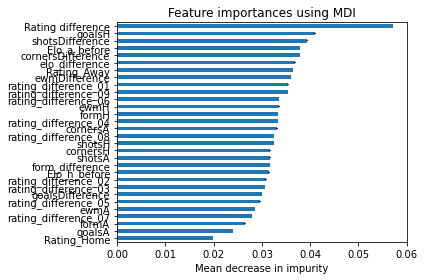

In [260]:
    #start_time = time.time()
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
#elapsed_time = time.time() - start_time


#feature_names = [f"feature {i}" for i in range(X.shape[1])]


forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values()
fig, ax = plt.subplots()

forest_importances.plot.barh(ax=ax, yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()

0.5336257309941521
Rating difference       0.049860
Elo_h_before            0.041813
shotsDifference         0.040420
Elo_a_before            0.039857
goalsH                  0.038024
Rating_Away             0.037826
ewmDifference           0.035640
elo_difference          0.035169
rating_difference_09    0.034692
ewmA                    0.034527
goalsDifference         0.034432
shotsH                  0.034284
cornersDifference       0.033871
rating_difference_01    0.033534
cornersA                0.033474
cornersH                0.032354
ewmH                    0.032096
rating_difference_08    0.032009
formH                   0.031886
form_difference         0.031580
rating_difference_05    0.031250
rating_difference_06    0.030968
rating_difference_02    0.030760
rating_difference_04    0.030757
rating_difference_07    0.030681
shotsA                  0.030256
rating_difference_03    0.030095
goalsA                  0.027957
formA                   0.027346
Rating_Home             

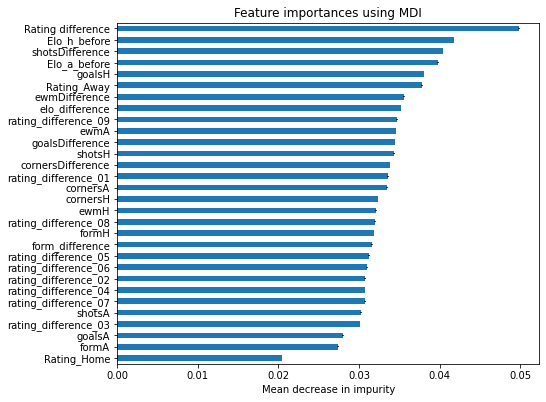

In [299]:
%%time
#split Data in training and test set
d_1 = 0
d_2 = 0
d_3 = 0
d_4 = 0
d_5 = 0
d_6 = 0
d_7 = 0
d_8 = 0
d_9 = 0
rating_dif = 0
rating_h = 0
rating_a = 0
ewm_h = 0
ewm_a = 0
ewm_dif = 0
elo_h = 0
elo_a = 0
elo_dif = 0
goals_h = 0
goals_a = 0
goals_dif = 0
shots_h = 0
shots_a = 0
shots_dif = 0
corners_h = 0
corners_a = 0
corners_dif = 0
form_h = 0
form_a = 0
form_dif = 0


score = []
i = 1000
for i in range(1, i):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    score.append(rf_model.score(X_test, y_test))
    #start_time = time.time()
    importances = rf_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
    #elapsed_time = time.time() - start_time


    #feature_names = [f"feature {i}" for i in range(X.shape[1])]


    forest_importances = pd.Series(importances, index=feature_names)


    d_1 = d_1 + forest_importances.rating_difference_01
    d_2 = d_2 + forest_importances.rating_difference_02
    d_3 = d_3 + forest_importances.rating_difference_03
    d_4 = d_4 + forest_importances.rating_difference_04
    d_5 = d_5 + forest_importances.rating_difference_05
    d_6 = d_6 + forest_importances.rating_difference_06
    d_7 = d_7 + forest_importances.rating_difference_07
    d_8 = d_8 + forest_importances.rating_difference_08
    d_9 = d_9 + forest_importances.rating_difference_09



    rating_dif = rating_dif + forest_importances['Rating difference']
    rating_h = rating_h + forest_importances.Rating_Home
    rating_a = rating_a + forest_importances.Rating_Away
    ewm_h = ewm_h + forest_importances.ewmH
    ewm_a = ewm_a + forest_importances.ewmA
    ewm_dif = ewm_dif + forest_importances.ewmDifference
    elo_h = elo_h + forest_importances.Elo_h_before
    elo_a = elo_a + forest_importances.Elo_a_before
    elo_dif = elo_dif+ forest_importances.elo_difference
    goals_h = goals_h+ forest_importances.goalsH
    goals_a = goals_a+ forest_importances.goalsA
    goals_dif = goals_dif+ forest_importances.goalsDifference
    shots_h = shots_h+ forest_importances.shotsH
    shots_a = shots_a+ forest_importances.shotsA
    shots_dif = shots_dif+ forest_importances.shotsDifference
    corners_h = corners_h+ forest_importances.cornersH
    corners_a = corners_a+ forest_importances.cornersA
    corners_dif = corners_dif+ forest_importances.cornersDifference
    form_h = form_h+ forest_importances.formH
    form_a = form_a+ forest_importances.formA
    form_dif = form_dif+ forest_importances.form_difference

fig, ax = plt.subplots()
forest_importances.rating_difference_01 = d_1/i
forest_importances.rating_difference_02 = d_2/i
forest_importances.rating_difference_03 = d_3/i
forest_importances.rating_difference_04 = d_4/i
forest_importances.rating_difference_05 = d_5/i
forest_importances.rating_difference_06 = d_6/i
forest_importances.rating_difference_07 = d_7/i
forest_importances.rating_difference_08 = d_8/i
forest_importances.rating_difference_09 = d_9/i
forest_importances['Rating difference'] = rating_dif/i
forest_importances.Rating_Home = rating_h/i
forest_importances.Rating_Away = rating_a/i
forest_importances.ewmH = ewm_h/i
forest_importances.ewmA = ewm_a/i
forest_importances.ewmDifference = ewm_dif/i
forest_importances.Elo_h_before = elo_h/i
forest_importances.Elo_h_before = elo_a/i
forest_importances.elo_difference = elo_dif/i
forest_importances.goalsH = goals_h/i
forest_importances.goalsA = goals_a/i
forest_importances.goalsDifference = goals_dif/i
forest_importances.shotsH = shots_h/i
forest_importances.shotsA = shots_a/i
forest_importances.shotsDifference = shots_dif/i
forest_importances.cornersH = corners_h/i
forest_importances.cornersA = corners_a/i
forest_importances.cornersDifference = corners_dif/i
forest_importances.formH = form_h/i
forest_importances.formA = form_a/i
forest_importances.form_difference = form_dif/i




forest_importances = forest_importances.sort_values()
forest_importances.plot.barh(ax=ax, yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout(pad=-5, w_pad=0.5, h_pad=-2)
print(np.mean(score))
print(forest_importances.sort_values(ascending=False))



In [311]:
#only stats with alpha = 0.9
player_ratings_09 =  pd.merge(player_ratings_a_09, PL20_21_fixtures, on= 'game_home_ID', how='left')
#create differences
player_ratings_09['gk_difference'] = player_ratings_09['rating_h_gk_09'] - player_ratings_09['rating_a_gk_09']
player_ratings_09['df_difference'] = player_ratings_09['rating_h_df_09'] - player_ratings_09['rating_a_df_09']
player_ratings_09['mf_difference'] = player_ratings_09['rating_h_mf_09'] - player_ratings_09['rating_a_mf_09']
player_ratings_09['att_difference'] = player_ratings_09['rating_h_att_09'] - player_ratings_09['rating_a_att_09']
player_ratings_09['bench_difference'] = player_ratings_09['rating_h_bench_09'] - player_ratings_09['rating_a_bench_09']
player_ratings_09['influence_difference'] = player_ratings_09['influence_h_09'] - player_ratings_09['influence_a_09']
player_ratings_09['creativity_difference'] = player_ratings_09['creativity_h_09'] - player_ratings_09['creativity_a_09']
player_ratings_09['threat_difference'] = player_ratings_09['threat_h_09'] - player_ratings_09['threat_a_09']
player_ratings_09['bps_difference'] = player_ratings_09['bps_h_09'] - player_ratings_09['bps_a_09']
player_ratings_09['selected_difference'] = player_ratings_09['selected_h_09'] - player_ratings_09['selected_a_09']
player_ratings_09['overall_h'] = player_ratings_09['rating_h_gk_09'] + player_ratings_09['rating_h_df_09'] + player_ratings_09['rating_h_mf_09'] + player_ratings_09['rating_h_att_09'] + player_ratings_09['rating_h_bench_09']
player_ratings_09['overall_a'] = player_ratings_09['rating_a_gk_09'] + player_ratings_09['rating_a_df_09'] + player_ratings_09['rating_a_mf_09'] + player_ratings_09['rating_a_att_09'] + player_ratings_09['rating_a_bench_09']
player_ratings_09['overall_difference'] = player_ratings_09['overall_h'] - player_ratings_09['overall_a']
player_ratings_09

,Unnamed: 0_09,Date_09,Time_09,HomeTeam_09,AwayTeam_09,FTHG_09,FTAG_09,FTR_09,game_home_ID,game_away_ID_09,...,att_difference,bench_difference,influence_difference,creativity_difference,threat_difference,bps_difference,selected_difference,overall_h,overall_a,overall_difference
0,0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,Fulham2020-09-12,Arsenal2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1,1,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,Crystal Palace2020-09-12,Southampton2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
2,2,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,Liverpool2020-09-12,Leeds United2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
3,3,2020-09-12,20:00,West Ham United,Newcastle United,0,2,A,West Ham United2020-09-12,Newcastle United2020-09-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
4,4,2020-09-13,14:00,West Bromwich Albion,Leicester City,0,3,A,West Bromwich Albion2020-09-13,Leicester City2020-09-13,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,375,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,Liverpool2021-05-23,Crystal Palace2021-05-23,...,14.278922,25.279522,158.174214,98.310169,95.265832,156.049672,5.900544e+06,451.836114,267.630667,184.205447
376,376,2021-05-23,16:00,Manchester City,Everton,5,0,H,Manchester City2021-05-23,Everton2021-05-23,...,-41.715032,70.551168,-57.490544,-115.984351,-44.672924,-102.847780,6.376243e+05,276.980872,355.553716,-78.572844
377,377,2021-05-23,16:00,Sheffield United,Burnley,1,0,H,Sheffield United2021-05-23,Burnley2021-05-23,...,27.336143,22.933582,27.687544,32.584193,-68.221724,33.241672,-6.920692e+05,349.741751,223.019166,126.722585
378,378,2021-05-23,16:00,West Ham United,Southampton,3,0,H,West Ham United2021-05-23,Southampton2021-05-23,...,83.344220,-15.656909,145.588167,70.495742,175.666343,79.939011,3.410067e+06,388.783331,378.471357,10.311974


In [340]:
score = []
score2 = []
i = 500
for i in range(1, i):
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    xgb_model = xgb.XGBClassifier(seed=82)
    xgb_model.fit(X_train, y_train)
    score2.append(xgb_model.score(X_test, y_test))
    score.append(rf_model.score(X_test, y_test))
print(np.mean(score))
print(np.mean(score2))

0.5336387059833952
0.47142857142857153


0.4868421052631579


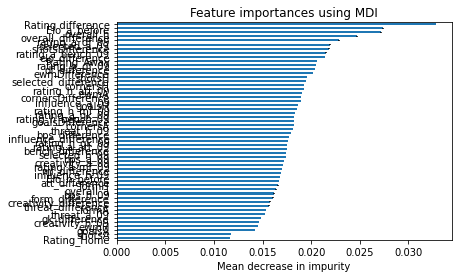

In [372]:
#prepare Data for ML Algos
#add column for H A X
#player_ratings_09_tmp = player_ratings_09.iloc[30:]
player_ratings_09_tmp = player_ratings_09
conditions = [
    (player_ratings_09_tmp['FTR_09'] == 'H'),
    (player_ratings_09_tmp['FTR_09'] == 'A'),
    (player_ratings_09_tmp['FTR_09'] == 'D')]
choices = [0, 1, 2]
player_ratings_09_tmp['identifier'] = np.select(conditions, choices)
#PL20_21_features.drop(PL20_21_features[ PL20_21_features.Wk < 6].index, inplace=True)
y = player_ratings_09_tmp['identifier'].to_numpy()
feature_names = ['rating_h_gk_09', 'Rating difference', 'Rating_Home', 'Rating_Away', 'ewmH', 'ewmA', 'ewmDifference', 'Elo_h_before','Elo_a_before', 'elo_difference', 'goalsH', 'goalsA', 'goalsDifference', 'shotsH', 'shotsA','shotsDifference', 'cornersH', 'cornersA', 'cornersDifference', 'formH', 'formA', 'form_difference', 'rating_a_gk_09', 'rating_h_df_09', 'rating_a_df_09', 'rating_h_mf_09', 'rating_a_mf_09', 'rating_h_att_09', 'rating_a_att_09', 'rating_h_bench_09', 'rating_a_bench_09', 'influence_h_09', 'influence_a_09', 'creativity_h_09', 'creativity_a_09', 'threat_h_09', 'threat_a_09', 'bps_h_09', 'bps_a_09', 'selected_h_09', 'selected_a_09', 'gk_difference', 'df_difference', 'mf_difference', 'att_difference', 'bench_difference','overall_difference' ,'influence_difference', 'creativity_difference', 'threat_difference', 'bps_difference', 'selected_difference', 'overall_h', 'overall_a']
#feature_names = ['Rating difference', 'Rating_Home', 'Rating_Away', 'ewmH', 'ewmA', 'ewmDifference', 'Elo_h_before','Elo_a_before', 'elo_difference', 'goalsH', 'goalsA', 'goalsDifference', 'shotsH', 'shotsA','shotsDifference', 'cornersH', 'cornersA', 'cornersDifference', 'formH', 'formA', 'form_difference']
X = player_ratings_09_tmp[feature_names].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
score.append(rf_model.score(X_test, y_test))
#start_time = time.time()
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
#elapsed_time = time.time() - start_time


#feature_names = [f"feature {i}" for i in range(X.shape[1])]


forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values()
fig, ax = plt.subplots()

forest_importances.plot.barh(ax=ax, yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
print(rf_model.score(X_test, y_test))

np_prob = rf_model.predict_proba(X=X)
df = pd.DataFrame(np_prob, columns = ['H','D','A'])
df
df.to_csv('Data/2020-21/Fixtures/probabilities.csv')
#fig.tight_layout(pad=-15, w_pad=0.5, h_pad=-2)